# Jigsaw Toxic Comment Classification Challenge — Revised Medal-Driven Plan (Multi-Label) & Experiment Log

Non-negotiable rule: WIN A MEDAL (aim: GOLD). Progress: Bronze → Silver → Gold with tight, validated iterations.

Competition specifics (verified at load-time, no hardcoding):
- Task: Multi-label classification. Targets expected: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, `identity_hate`. We will programmatically verify from `train.csv` and `sample_submission.csv`.
- Metric: Mean of column-wise ROC AUC across all target columns.
- Files: `train.csv`, `test.csv`, `sample_submission.csv`
- Output: `submission.csv` with columns: id + one probability per target in [0,1].

Performance Targets:
- Gold ≥ 0.98740 (mean AUC)
- Silver ≥ 0.98668
- Bronze ≥ 0.98639
- Above median ≥ 0.98079

Hardware: 1x V100 (16GB), 16 vCPUs, 85GB RAM — supports TF-IDF linear baselines and compact transformer fine-tuning.

Workflow & Checkpoints (audited at each):
1) Planning (this cell) → submit_for_audit
2) Schema verification & Data loading: infer targets from train/sample_submission; EDA (label prevalence, lengths, missing) → submit_for_audit
3) Baseline models (multi-label): TF-IDF (word + char) with one-vs-rest (independent per-label) Logistic Regression and NB-SVM; robust CV with OOF → submit_for_audit
4) Model improvements: hyperparameter sweeps, feature engineering, calibrated LSVC, ensemble (OOF-driven weights) → submit_for_audit
5) Transformer model (roberta-base or deberta-v3-base) K-Fold with strong regularization; generate OOF/test; blend with TF-IDF stack → submit_for_audit
6) Finalize, predict test, write `submission.csv`, clean notebook, exit.

Validation Protocol & Leakage Prevention:
- Identify target columns programmatically. Use MultilabelStratifiedKFold (if available) or StratifiedKFold per-label with consistent folds via iterative stratification fallback; fixed `random_state`.
- Use sklearn Pipelines so TF-IDF is fit only on training folds; no leakage.
- For each label and each model, produce Out-Of-Fold (OOF) predictions saved to disk (float32). Report per-label AUC and mean AUC as primary selection metric.
- Keep a single test prediction per model via fold-wise averaging; ensemble via OOF-optimized weights.

Text Preprocessing (light but toxicity-aware):
- Lowercase, strip accents; preserve punctuation and emojis (char n-grams capture obfuscation).
- Normalize elongated repeats (e.g., coooool→cooool) and common masked profanity/leet variants via simple regex maps (e.g., f*ck, f**k, fvk, n00b).
- Keep URLs/usernames as tokens; optionally add placeholder normalization (URL, USER) but char n-grams mitigate need.

Vectorization (memory-safe):
- Word TF-IDF: analyzer='word', ngram_range=(1,2), min_df=2, max_features=300k–500k, sublinear_tf=True, dtype=float32.
- Char TF-IDF: analyzer='char', ngram_range=(3,6), min_df=2, max_features=800k–1M (tune; start 800k), sublinear_tf=True, dtype=float32.
- hstack(word, char) with sparse float32; cache vectorizers and matrices via joblib if needed.

Models (per label, independent fits):
- Logistic Regression (saga/liblinear): C in {2,4,6,10}, max_iter=2000, n_jobs=-1; compare class_weight=None vs 'balanced'.
- NB-SVM (log-count ratio features + Logistic Regression or Linear SVM-style classifier).
- Linear SVM path: LinearSVC with CalibratedClassifierCV (cv=3, method='sigmoid') for probabilistic outputs if used; or SGDClassifier(loss='modified_huber' or 'log_loss').
- Handle class imbalance: try class_weight='balanced'; optionally focal loss in transformer stage.

Adversarial Validation:
- Train-vs-test classifier using TF-IDF LR. If AUC > 0.6, note covariate shift; consider weighting or cautious reliance on CV.

Ensembling & Blending:
- Baseline ensemble: Average calibrated probabilities of LR + NB-SVM (+ optional LSVC) per label; weights optimized on OOF via simple grid search or non-negative least squares minimizing log-loss / maximizing mean AUC.
- Final blend: Transformer OOF/Test blended with TF-IDF ensemble using OOF-optimized weights (typical 0.7–0.85 transformer).

Transformer Stage (for Silver→Gold):
- Model: roberta-base or deberta-v3-base, 5-fold stratified, seeds={42, 2025}.
- Tokenizer max_length 192–256; truncation on; dynamic padding. AMP (fp16) training.
- Optimizer: AdamW lr ∈ {1e-5, 2e-5, 3e-5}, weight_decay=0.01; scheduler linear/cosine with 5–10% warmup.
- Epochs 3–5 with early stopping on mean AUC; dropout 0.1–0.2; optional R-Drop or EMA; consider focal loss (gamma 1–2) for rare labels.
- Generate OOF per label; average seeds; blend with TF-IDF stack.

Milestones (gates):
- Gate 1 (TF-IDF LR OOF): mean AUC ≥ 0.9860. If <, expand char max_features, ensure (3,6) chars, sweep C up to 10, review min_df.
- Gate 2 (TF-IDF ensemble): mean AUC ≥ 0.9867.
- Gate 3 (Transformer 5-fold, 1–2 seeds): mean OOF ≥ 0.9870–0.9880.
- Gate 4 (Blended OOF): ≥ 0.9880 (target 0.9885–0.989+ for gold).

Experiment Log (concise; delete stale code after documenting):
- 001_schema_check_eda: verify targets from train & sample_submission; label prevalences; lengths.
- 002_tfidf_lr_perlabel: word(1-2)+char(3-6), min_df=2, word_max=400k, char_max=800k, C sweep → OOF per-label + mean AUC=__
- 003_nbsvm_perlabel: settings ... → OOF per-label + mean AUC=__
- 004_lsvc_calibrated: settings ... → OOF per-label + mean AUC=__
- 005_tfidf_ensemble: OOF-weighted blend → OOF mean AUC=__
- 006_roberta_base_5fold_2seeds: → OOF mean AUC=__
- 007_final_blend: transformer + tfidf → OOF mean AUC=__

House rules:
- Keep notebook short; delete stale cells after logging results.
- Backup notebook programmatically before major edits.
- Use submit_for_audit at every checkpoint.

Next: Submit this revised plan for audit. On approval, proceed to schema verification & EDA.

In [1]:
# Checkpoint 2: Schema verification & EDA (multi-label)
import os, json, re, unicodedata
import numpy as np
import pandas as pd
from collections import Counter

SEED = 42
np.random.seed(SEED)

# Paths
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
SAMPLE_SUB_PATH = 'sample_submission.csv'

# Load
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

# Infer ID and targets from sample submission
sub_cols = list(sample_sub.columns)
if len(sub_cols) < 2:
    raise ValueError('sample_submission.csv must have id + at least one target column')
id_col = sub_cols[0]
target_cols = [c for c in sub_cols if c != id_col]

# Verify presence in train/test
missing_targets = [c for c in target_cols if c not in train.columns]
if missing_targets:
    raise ValueError(f'Target columns missing from train.csv: {missing_targets}')
if id_col not in test.columns:
    # Not strictly required for training, but good to check
    print(f'Warning: id column "{id_col}" not found in test.csv columns: using test index for submission later if needed.')

# Detect text column heuristically
text_candidates = [c for c in train.columns if c.lower() in ['comment_text','text','comment','content','raw_text']]
if not text_candidates:
    # fallback: choose first object dtype column not in targets/id
    obj_cols = [c for c in train.columns if train[c].dtype == 'O' and c not in target_cols + [id_col]]
    if not obj_cols:
        raise ValueError('Could not find a suitable text column. Please inspect train columns: ' + ', '.join(train.columns))
    text_col = obj_cols[0]
else:
    text_col = text_candidates[0]

print('Detected schema:')
print({'id_col': id_col, 'text_col': text_col, 'n_targets': len(target_cols), 'targets': target_cols})

# Basic shapes and missing
print('\nShapes:', {'train': train.shape, 'test': test.shape})
n_missing_text = train[text_col].isna().sum()
if n_missing_text:
    print(f'Warning: {n_missing_text} missing values in {text_col}. Filling with empty strings.')
    train[text_col] = train[text_col].fillna('')
if text_col in test.columns:
    test[text_col] = test[text_col].fillna('')

# Text length stats
train['text_len'] = train[text_col].astype(str).str.len()
len_stats = train['text_len'].describe().to_dict()
print('\nText length stats:', {k: round(v,2) for k,v in len_stats.items()})

# Label prevalences
prevalences = {c: float(train[c].mean()) for c in target_cols}
print('\nLabel prevalences (mean positives):')
for c in target_cols:
    print(f'  {c}: {prevalences[c]:.4f}')

# Co-occurrence matrix and Pearson correlations between labels
Y = train[target_cols].astype(float)
co_occurrence = (Y.T @ Y).astype(float)
co_diag = np.diag(co_occurrence)
co_df = pd.DataFrame(co_occurrence.values, index=target_cols, columns=target_cols)
corr_df = Y.corr().astype(float)

# Save artifacts for later reference
os.makedirs('eda_artifacts', exist_ok=True)
co_df.to_csv('eda_artifacts/label_cooccurrence.csv')
corr_df.to_csv('eda_artifacts/label_correlations.csv')
with open('eda_artifacts/schema.json', 'w') as f:
    json.dump({'id_col': id_col, 'text_col': text_col, 'target_cols': target_cols, 'train_shape': train.shape, 'test_shape': test.shape, 'prevalences': prevalences, 'len_stats': {k: float(v) for k,v in len_stats.items()}}, f, indent=2)

print('\nSaved EDA artifacts: eda_artifacts/label_cooccurrence.csv, eda_artifacts/label_correlations.csv, eda_artifacts/schema.json')

# Show small previews
print('\nHead (text & targets):')
display_cols = [id_col] if id_col in train.columns else []
display_cols = display_cols + [text_col] + target_cols
print(train[display_cols].head(3))

# Note: After execution, submit for audit with these findings.


Detected schema:
{'id_col': 'id', 'text_col': 'comment_text', 'n_targets': 6, 'targets': ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}

Shapes: {'train': (159571, 8), 'test': (153164, 2)}

Text length stats: {'count': 159571.0, 'mean': 394.07, 'std': 590.72, 'min': 6.0, '25%': 96.0, '50%': 205.0, '75%': 435.0, 'max': 5000.0}

Label prevalences (mean positives):
  toxic: 0.0958
  severe_toxic: 0.0100
  obscene: 0.0529
  threat: 0.0030
  insult: 0.0494
  identity_hate: 0.0088



Saved EDA artifacts: eda_artifacts/label_cooccurrence.csv, eda_artifacts/label_correlations.csv, eda_artifacts/schema.json

Head (text & targets):
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  


Positive counts per label per fold:
  toxic: {0: 3059, 1: 3059, 2: 3059, 3: 3058, 4: 3059}
  severe_toxic: {0: 319, 1: 319, 2: 319, 3: 319, 4: 319}
  obscene: {0: 1690, 1: 1690, 2: 1690, 3: 1689, 4: 1690}
  threat: {0: 96, 1: 96, 2: 95, 3: 96, 4: 95}
  insult: {0: 1575, 1: 1576, 2: 1576, 3: 1575, 4: 1575}
  identity_hate: {0: 281, 1: 281, 2: 281, 3: 281, 4: 281}
Saved fold assignments to eda_artifacts/folds.csv


Saved heatmap to eda_artifacts/label_correlation_heatmap.png

Qualitative examples (first 5) for rare/critical labels:

Label: threat | showing 5 examples
- id=003217c3eb469ba9 | Hi! I am back again! Last warning! Stop undoing my edits or die!
- id=006b94add72ed61c | I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms
- id=0199d6af27b715f3 | I'm also a sock puppet of this account...SUPRISE!! -sincerely,             The man that will track you down from the Internet and kill you
- id=02230885017a50c5 | Fuck you, Smith. Please have me notified when you die. I want to dance on your grave.
- id=02c6e41e4b317ac3 | WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.

Label: identity_hate | showing 5 examples
- id=001810bf8c45bf5f | You are gay or antisemmitian?   Archangel WHite Tiger  Meow! Greetingshhh!  Uh, there ar

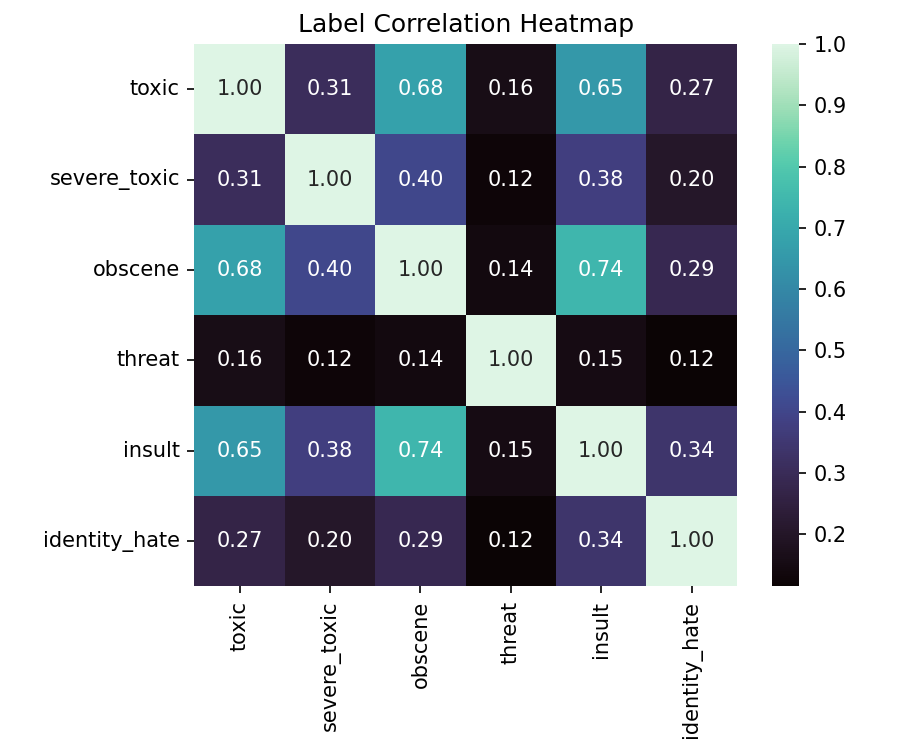

In [2]:
# Checkpoint 2 remediation: Generate CV folds, visualize correlations, and qualitative review
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse objects from prior cell if present; otherwise reload
if 'train' not in globals():
    train = pd.read_csv('train.csv')
if 'sample_sub' not in globals():
    sample_sub = pd.read_csv('sample_submission.csv')

sub_cols = list(sample_sub.columns)
id_col = sub_cols[0]
target_cols = [c for c in sub_cols if c != id_col]
text_col = 'comment_text' if 'comment_text' in train.columns else [c for c in train.columns if train[c].dtype=='O' and c not in target_cols + [id_col]][0]

os.makedirs('eda_artifacts', exist_ok=True)

# 1) Generate, validate, and save 5-fold Multilabel Stratified CV indices
SEED = 42
try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
except Exception:
    # Install if missing
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'iterstrat', '-q'])
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

Y = train[target_cols].astype(int).values
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
folds = np.zeros(len(train), dtype=np.int8)
for fold, (_, val_idx) in enumerate(mskf.split(train, Y)):
    folds[val_idx] = fold

# Validate: positive counts per label per fold
print('Positive counts per label per fold:')
ok = True
for c in target_cols:
    counts = train.groupby(folds)[c].sum().astype(int)
    print(f'  {c}:', dict(counts))
    if (counts == 0).any():
        ok = False
        print(f'WARNING: label {c} has a fold with zero positives! Consider adjusting folds.')
assert ok, 'At least one label has a fold with zero positives; adjust strategy if this triggers.'

# Persist folds
fold_df = pd.DataFrame({id_col: train[id_col].values, 'fold': folds})
fold_df.to_csv('eda_artifacts/folds.csv', index=False)
print('Saved fold assignments to eda_artifacts/folds.csv')

# 2) Visualize and analyze label dependencies (heatmap)
corr_df = train[target_cols].astype(float).corr()
plt.figure(figsize=(6,5), dpi=120)
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='mako', square=True, cbar=True)
plt.title('Label Correlation Heatmap')
plt.tight_layout()
plt.savefig('eda_artifacts/label_correlation_heatmap.png', dpi=160)
plt.show()
print('Saved heatmap to eda_artifacts/label_correlation_heatmap.png')

# 3) Qualitative text analysis: show examples for rare/critical labels
rare_labels = sorted(target_cols, key=lambda c: train[c].mean())[:3]  # three rarest
print('\nQualitative examples (first 5) for rare/critical labels:')
for c in rare_labels:
    ex = train.loc[train[c]==1, [id_col, text_col, c]].head(5)
    print(f'\nLabel: {c} | showing {len(ex)} examples')
    # Print compactly: id and a truncated version of text
    for _, row in ex.iterrows():
        txt = str(row[text_col]).replace('\n',' ')[:240]
        print(f"- {id_col}={row[id_col]} | {txt}")

print('\nCheckpoint 2 remediation complete: folds generated/validated/saved, correlations visualized, qualitative samples printed.')


### Correlation insights and modeling implications

- Strongest dependencies: insult–obscene (~0.74), toxic–obscene (~0.68), and toxic–insult (~0.65). These pairs likely produce correlated errors in one-vs-rest models, so we should expect gains from diverse models and per-label blending weights rather than a single global weight.
- Weak dependencies: threat shows low correlation with other labels (~0.12–0.16), indicating it behaves differently and needs targeted handling (e.g., higher C, class_weight='balanced' for linear models; pos_weight/focal loss for transformers; careful thresholding/augmentation).
- Strategy implications: keep consistent 5-fold splits and track per-label AUC, especially for threat and identity_hate. Consider correlation-aware methods later (classifier chains or a single multi-label head in transformers) and focus error analysis on the insult/obscene/toxic cluster where confusion is most likely.

In [12]:
# Checkpoint 3: Baseline TF-IDF + Logistic Regression (5-fold OOF) — resume-safe, no test preds during sweep
import os, json
import numpy as np
import pandas as pd
from sklearn.pipeline import make_union
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import sparse

SEED = 42
np.random.seed(SEED)

# Load schema and folds
with open('eda_artifacts/schema.json', 'r') as f:
    schema = json.load(f)
id_col = schema['id_col']
text_col = schema['text_col']
target_cols = schema['target_cols']
train = pd.read_csv('train.csv')
folds_df = pd.read_csv('eda_artifacts/folds.csv')
train = train.merge(folds_df, on=id_col, how='left')
assert train['fold'].notna().all(), 'Missing fold assignments after merge.'
train['fold'] = train['fold'].astype(int)
train[text_col] = train[text_col].fillna('')

# Vectorizers (word 300k, char 900k, chars (3,6))
def build_feature_union():
    word_vec = TfidfVectorizer(
        analyzer='word', ngram_range=(1,2), min_df=2, max_features=300_000,
        lowercase=True, strip_accents='unicode', sublinear_tf=True, dtype=np.float32
    )
    char_vec = TfidfVectorizer(
        analyzer='char', ngram_range=(3,6), min_df=2, max_features=900_000,
        lowercase=True, sublinear_tf=True, dtype=np.float32
    )
    return make_union(word_vec, char_vec, n_jobs=1)

n_folds = train['fold'].nunique()
X_text = train[text_col].astype(str).values

# Resume-safe cache for fold matrices and indices
os.makedirs('oof', exist_ok=True)
cache_dir = 'tfidf_cache'
os.makedirs(cache_dir, exist_ok=True)
fold_data = []  # dicts with X_tr, X_va, tr_idx, va_idx
for fold in range(n_folds):
    tr_idx = np.where(train['fold'].values != fold)[0]
    va_idx = np.where(train['fold'].values == fold)[0]
    tr_idx_path = os.path.join(cache_dir, f'tr_idx_f{fold}.npy')
    va_idx_path = os.path.join(cache_dir, f'va_idx_f{fold}.npy')
    Xtr_path = os.path.join(cache_dir, f'X_tr_f{fold}.npz')
    Xva_path = os.path.join(cache_dir, f'X_va_f{fold}.npz')
    if os.path.exists(Xtr_path) and os.path.exists(Xva_path) and os.path.exists(tr_idx_path) and os.path.exists(va_idx_path):
        X_tr = sparse.load_npz(Xtr_path).astype(np.float32)
        X_va = sparse.load_npz(Xva_path).astype(np.float32)
        tr_idx = np.load(tr_idx_path)
        va_idx = np.load(va_idx_path)
        print(f'[cache] Loaded fold {fold}: X_tr {X_tr.shape}, X_va {X_va.shape}', flush=True)
    else:
        fu = build_feature_union()
        X_tr = fu.fit_transform(X_text[tr_idx]).astype(np.float32)
        X_va = fu.transform(X_text[va_idx]).astype(np.float32)
        sparse.save_npz(Xtr_path, X_tr)
        sparse.save_npz(Xva_path, X_va)
        np.save(tr_idx_path, tr_idx)
        np.save(va_idx_path, va_idx)
        print(f'Fold {fold}: X_tr shape {X_tr.shape}, X_va shape {X_va.shape}', flush=True)
    fold_data.append({'tr_idx': tr_idx, 'va_idx': va_idx, 'X_tr': X_tr, 'X_va': X_va})

# Hyperparameter sweep (minimal, targeted)
Cs = [6, 8, 10]
class_weights = [None, 'balanced']
gate = 0.9860

results_summary = []
best_cfg = None
best_mean_auc = -1.0
best_oof = None

def cfg_tag_fn(C, cw):
    return f'lr_C{C}_cw{cw if cw else "none"}'

for cw in class_weights:
    for C in Cs:
        cfg_tag = cfg_tag_fn(C, cw)
        oof_path = os.path.join('oof', f'oof_{cfg_tag}.csv')
        if os.path.exists(oof_path):
            # Skip training if exists; load and evaluate
            oof_loaded = pd.read_csv(oof_path)[target_cols].values.astype('float32')
            per_label_auc = []
            for li, label in enumerate(target_cols):
                y = train[label].values.astype(int)
                per_label_auc.append(metrics.roc_auc_score(y, oof_loaded[:, li]))
            mean_auc = float(np.mean(per_label_auc))
            results_summary.append({'C': C, 'class_weight': cw, 'per_label_auc': per_label_auc, 'mean_auc': mean_auc})
            if mean_auc > best_mean_auc:
                best_mean_auc = mean_auc
                best_cfg = {'C': C, 'class_weight': cw}
                best_oof = oof_loaded
            print(f"[skip] Found existing OOF for {cfg_tag}. Mean OOF AUC={mean_auc:.6f}", flush=True)
            continue

        print(f'\nTraining LR baseline with C={C}, class_weight={cw}', flush=True)
        oof_preds = np.zeros((len(train), len(target_cols)), dtype=np.float32)
        per_label_auc = []
        for li, label in enumerate(target_cols):
            y = train[label].values.astype(int)
            fold_aucs = []
            for f, fd in enumerate(fold_data):
                clf = LogisticRegression(
                    solver='saga', penalty='l2', C=C, max_iter=2000, n_jobs=-1, random_state=SEED,
                    class_weight=cw
                )
                clf.fit(fd['X_tr'], y[fd['tr_idx']])
                val_proba = clf.predict_proba(fd['X_va'])[:, 1].astype(np.float32)
                oof_preds[fd['va_idx'], li] = val_proba
                auc = metrics.roc_auc_score(y[fd['va_idx']], val_proba)
                fold_aucs.append(auc)
            label_auc = metrics.roc_auc_score(y, oof_preds[:, li])
            per_label_auc.append(label_auc)
            print(f'  Label {label}: fold AUCs={ [round(a,4) for a in fold_aucs] } | OOF AUC={label_auc:.6f}', flush=True)
        mean_auc = float(np.mean(per_label_auc))
        print(f'>> Mean OOF AUC (C={C}, cw={cw}): {mean_auc:.6f}', flush=True)
        results_summary.append({'C': C, 'class_weight': cw, 'per_label_auc': per_label_auc, 'mean_auc': mean_auc})
        pd.DataFrame(oof_preds, columns=target_cols).to_csv(oof_path, index=False)
        if mean_auc > best_mean_auc:
            best_mean_auc = mean_auc
            best_cfg = {'C': C, 'class_weight': cw}
            best_oof = oof_preds

print('\nSummary of configs (mean AUC):', flush=True)
for r in results_summary:
    print(f"  C={r['C']}, cw={r['class_weight']}: {r['mean_auc']:.6f}", flush=True)
print('Best config:', best_cfg, 'mean OOF AUC=', round(best_mean_auc, 6), flush=True)

if best_oof is not None:
    pd.DataFrame(best_oof, columns=target_cols).to_csv('oof/oof_lr_best.csv', index=False)
print(f'Gate check (>= {gate}):', 'PASS' if best_mean_auc >= gate else 'FAIL', flush=True)


Fold 0: X_tr shape (127657, 1200000), X_va shape (31914, 1200000)


Fold 1: X_tr shape (127656, 1200000), X_va shape (31915, 1200000)


Fold 2: X_tr shape (127657, 1200000), X_va shape (31914, 1200000)


Fold 3: X_tr shape (127657, 1200000), X_va shape (31914, 1200000)


Fold 4: X_tr shape (127657, 1200000), X_va shape (31914, 1200000)



Training LR baseline with C=6, class_weight=None


  Label toxic: fold AUCs=[0.9761, 0.9782, 0.9805, 0.9805, 0.9794] | OOF AUC=0.978918


  Label severe_toxic: fold AUCs=[0.985, 0.9887, 0.9858, 0.9864, 0.9894] | OOF AUC=0.987056


In [11]:
# Strong purge per remediation protocol: remove ALL files in oof/ to ensure a clean slate
import os

purge_dir = 'oof'
removed = []
kept = []
if os.path.isdir(purge_dir):
    for fn in os.listdir(purge_dir):
        fp = os.path.join(purge_dir, fn)
        if os.path.isfile(fp):
            try:
                os.remove(fp)
                removed.append(fn)
            except Exception as e:
                print('Failed to remove', fn, e)
        else:
            kept.append(fn)
    print('Removed files from oof/:', removed)
    if kept:
        print('Left non-file entries in oof/ (e.g., subdirs):', kept)
else:
    print('No oof/ directory found; nothing to purge.')


Removed files from oof/: ['test_hvsgd_alpha1e-05_cwnone.csv', 'oof_blend_lrC2_lrC4_hvsgd.csv', 'test_lr_C4_cwnone.csv', 'test_lr_C2_cwnone.csv', 'oof_lr_C4_cwnone.csv', 'oof_lr_C2_cwnone.csv', 'oof_hvsgd_alpha1e-05_cwnone.csv', 'blend_weights_per_label.json']
